OLS in simple regression

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm

# Generate synthetic data
rng = np.random.default_rng(2025)
n = 1200
beta0_true, beta1_true = 0.02, 0.75
X = rng.normal(0.0, 1.2, n)
eps = rng.normal(0.0, 0.45, n)
Y = beta0_true + beta1_true * X + eps

df = pd.DataFrame({"X": X, "Y": Y})

# Closed-form OLS estimators
xbar, ybar = df["X"].mean(), df["Y"].mean()
Sxx = float(((df["X"] - xbar)**2).sum())
Sxy = float(((df["X"] - xbar)*(df["Y"] - ybar)).sum())

beta1_hat = Sxy / Sxx
beta0_hat = ybar - beta1_hat * xbar

# Fitted values, residuals, variance estimate
Y_hat = beta0_hat + beta1_hat * df["X"].to_numpy()
resid = df["Y"].to_numpy() - Y_hat
df_resid = n - 2
sigma2_hat = (resid @ resid) / df_resid

# Standard errors
se_beta1 = np.sqrt(sigma2_hat / Sxx)
se_beta0 = np.sqrt(sigma2_hat * (1.0/n + (xbar**2)/Sxx))

# t-stats, two-sided 95% CIs
t_beta1 = beta1_hat / se_beta1
t_beta0 = beta0_hat / se_beta0
tcrit = stats.t.ppf(0.975, df_resid)
ci_beta1 = (beta1_hat - tcrit*se_beta1, beta1_hat + tcrit*se_beta1)
ci_beta0 = (beta0_hat - tcrit*se_beta0, beta0_hat + tcrit*se_beta0)

# Goodness of fit
TSS = float(((df["Y"] - ybar)**2).sum())
RSS = float((resid**2).sum())
R2 = 1.0 - RSS / TSS
adj_R2 = 1.0 - (1.0 - R2) * (n - 1) / (n - 2)

# statsmodels cross-check
X1 = sm.add_constant(df["X"].to_numpy(), has_constant="add")
ols = sm.OLS(df["Y"].to_numpy(), X1).fit()
ols_hc1 = ols.get_robustcov_results(cov_type="HC1")

# Mean-response CI and prediction interval at x0
#    mean CI: yhat ± tcrit * sqrt( sigma^2 * [ 1/n + (x0 - xbar)^2 / Sxx ] )
#    pred PI: yhat ± tcrit * sqrt( sigma^2 * [ 1 + 1/n + (x0 - xbar)^2 / Sxx ] )
x0 = 1.00
y0_hat = beta0_hat + beta1_hat * x0
se_mean = np.sqrt(sigma2_hat * (1.0/n + ((x0 - xbar)**2)/Sxx))
se_pred = np.sqrt(sigma2_hat * (1.0 + 1.0/n + ((x0 - xbar)**2)/Sxx))
ci_mean = (y0_hat - tcrit*se_mean, y0_hat + tcrit*se_mean)
pi_pred = (y0_hat - tcrit*se_pred, y0_hat + tcrit*se_pred)

# statsmodels check via get_prediction
pred = ols.get_prediction(exog=[1.0, x0])
ci_mean_sm = tuple(pred.summary_frame(alpha=0.05)[["mean_ci_lower","mean_ci_upper"]].iloc[0])
pi_pred_sm = tuple(pred.summary_frame(alpha=0.05)[["obs_ci_lower","obs_ci_upper"]].iloc[0])

print("="*72)
print("Simple Linear Regression — OLS (closed-form) vs statsmodels")
print("="*72)
print(f"True betas      : beta0={beta0_true:.3f}, beta1={beta1_true:.3f}")
print(f"Closed-form OLS : beta0={beta0_hat:.3f} (se={se_beta0:.3f}, t={beta0_hat/se_beta0:.2f}, CI95={ci_beta0})")
print(f"                  beta1={beta1_hat:.3f} (se={se_beta1:.3f}, t={t_beta1:.2f}, CI95={ci_beta1})")
print(f"Fit             : R^2={R2:.4f}, adj R^2={adj_R2:.4f}")
print("-"*72)
print("statsmodels OLS (homoskedastic):")
print(f"  beta0={ols.params[0]:.3f} (se={ols.bse[0]:.3f}), "
      f"beta1={ols.params[1]:.3f} (se={ols.bse[1]:.3f}), R^2={ols.rsquared:.4f}")
print("statsmodels OLS (HC1 robust SE):")
print(f"  beta0={ols_hc1.params[0]:.3f} (se={ols_hc1.bse[0]:.3f}), "
      f"beta1={ols_hc1.params[1]:.3f} (se={ols_hc1.bse[1]:.3f})")
print("-"*72)
print(f"Mean-response CI at x0={x0:.2f} : {ci_mean} (closed-form) vs {ci_mean_sm} (sm)")
print(f"Prediction interval at x0={x0:.2f}: {pi_pred} (closed-form) vs {pi_pred_sm} (sm)")
print("="*72)

Simple Linear Regression — OLS (closed-form) vs statsmodels
True betas      : beta0=0.020, beta1=0.750
Closed-form OLS : beta0=0.003 (se=0.013, t=0.25, CI95=(np.float64(-0.022367787047077002), np.float64(0.028988837442635945)))
                  beta1=0.758 (se=0.011, t=69.30, CI95=(np.float64(0.736394877958875), np.float64(0.7793051122689277)))
Fit             : R^2=0.8004, adj R^2=0.8002
------------------------------------------------------------------------
statsmodels OLS (homoskedastic):
  beta0=0.003 (se=0.013), beta1=0.758 (se=0.011), R^2=0.8004
statsmodels OLS (HC1 robust SE):
  beta0=0.003 (se=0.013), beta1=0.758 (se=0.011)
------------------------------------------------------------------------
Mean-response CI at x0=1.00 : (np.float64(0.7273899445498223), np.float64(0.7949310960735395)) (closed-form) vs (0.727389944549822, 0.7949310960735392) (sm)
Prediction interval at x0=1.00: (np.float64(-0.12884543567577822), np.float64(1.65116647629914)) (closed-form) vs (-0.1288454356

Confidence intervals of slope and intercept

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm


# Synthetic data
rng = np.random.default_rng(101)
n = 1000
beta0_true, beta1_true = 0.02, 0.80
X = rng.normal(0.0, 1.0, n)
# Heteroskedastic errors: variance increases with |X|
sigma = 0.30 * (1.0 + 0.7 * np.abs(X))
eps = rng.normal(0.0, sigma, n)
Y = beta0_true + beta1_true * X + eps

df = pd.DataFrame({"X": X, "Y": Y})


# Classical OLS (closed-form) and CIs
xbar, ybar = df["X"].mean(), df["Y"].mean()
Sxx = float(((df["X"] - xbar)**2).sum())
Sxy = float(((df["X"] - xbar)*(df["Y"] - ybar)).sum())

beta1_hat = Sxy / Sxx
beta0_hat = ybar - beta1_hat * xbar

# Residual variance (homoskedastic OLS)
Y_hat = beta0_hat + beta1_hat * df["X"].to_numpy()
resid = df["Y"].to_numpy() - Y_hat
df_resid = n - 2
sigma2_hat = (resid @ resid) / df_resid

# Standard errors
se_beta1 = np.sqrt(sigma2_hat / Sxx)
se_beta0 = np.sqrt(sigma2_hat * (1.0/n + (xbar**2)/Sxx))

# 95% CIs using Student-t with (n-2) dof
tcrit = stats.t.ppf(0.975, df_resid)
ci_beta1_classical = (beta1_hat - tcrit*se_beta1, beta1_hat + tcrit*se_beta1)
ci_beta0_classical = (beta0_hat - tcrit*se_beta0, beta0_hat + tcrit*se_beta0)


# HC1-robust CIs via statsmodels
X1 = sm.add_constant(df["X"].to_numpy(), has_constant="add")
ols = sm.OLS(df["Y"].to_numpy(), X1).fit()
ols_hc1 = ols.get_robustcov_results(cov_type="HC1")  # heteroskedasticity-robust

beta0_sm, beta1_sm = float(ols_hc1.params[0]), float(ols_hc1.params[1])
se_beta0_hc1, se_beta1_hc1 = float(ols_hc1.bse[0]), float(ols_hc1.bse[1])

# Use the same t critical (large-sample normal would give a similar result)
ci_beta1_hc1 = (beta1_sm - tcrit*se_beta1_hc1, beta1_sm + tcrit*se_beta1_hc1)
ci_beta0_hc1 = (beta0_sm - tcrit*se_beta0_hc1, beta0_sm + tcrit*se_beta0_hc1)

def fmt(ci): return f"({ci[0]:.3f}, {ci[1]:.3f})"

print("="*72)
print("Confidence Intervals for Simple Linear Regression Coefficients")
print("="*72)
print(f"True betas: beta0={beta0_true:.3f}, beta1={beta1_true:.3f}\n")

print("Classical OLS (homoskedastic) estimates & 95% CIs:")
print(f"  beta0_hat={beta0_hat:.3f}, CI95={fmt(ci_beta0_classical)}")
print(f"  beta1_hat={beta1_hat:.3f}, CI95={fmt(ci_beta1_classical)}\n")

print("HC1-robust (heteroskedasticity-robust) estimates & 95% CIs:")
print(f"  beta0_sm ={beta0_sm:.3f},  CI95={fmt(ci_beta0_hc1)}")
print(f"  beta1_sm ={beta1_sm:.3f},  CI95={fmt(ci_beta1_hc1)}")
print("="*72)

Confidence Intervals for Simple Linear Regression Coefficients
True betas: beta0=0.020, beta1=0.800

Classical OLS (homoskedastic) estimates & 95% CIs:
  beta0_hat=0.013, CI95=(-0.017, 0.044)
  beta1_hat=0.842, CI95=(0.813, 0.871)

HC1-robust (heteroskedasticity-robust) estimates & 95% CIs:
  beta0_sm =0.013,  CI95=(-0.017, 0.044)
  beta1_sm =0.842,  CI95=(0.804, 0.880)


Confidence interval of the mean response

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm

# Synthetic data
rng = np.random.default_rng(314)
n = 1000
beta0_true, beta1_true = 0.02, 0.80
X = rng.normal(0.0, 1.0, n)
# Heteroskedastic errors: variance grows with |X|
sigma = 0.35 * (1.0 + 0.7 * np.abs(X))
eps = rng.normal(0.0, sigma, n)
Y = beta0_true + beta1_true * X + eps

df = pd.DataFrame({"X": X, "Y": Y})


# Closed-form OLS estimates
xbar, ybar = df["X"].mean(), df["Y"].mean()
Sxx = float(((df["X"] - xbar)**2).sum())
Sxy = float(((df["X"] - xbar)*(df["Y"] - ybar)).sum())

beta1_hat = Sxy / Sxx
beta0_hat = ybar - beta1_hat * xbar

Y_hat = beta0_hat + beta1_hat * df["X"].to_numpy()
resid = df["Y"].to_numpy() - Y_hat
df_resid = n - 2
sigma2_hat = (resid @ resid) / df_resid
tcrit = stats.t.ppf(0.975, df_resid)  # 95% two-sided


# HC1-robust covariance for parameters
X1 = sm.add_constant(df["X"].to_numpy(), has_constant="add")
ols = sm.OLS(df["Y"].to_numpy(), X1).fit()
ols_hc1 = ols.get_robustcov_results(cov_type="HC1")
Cov_hc1 = ols_hc1.cov_params()  # 2x2 covariance of [beta0, beta1]


# CI for mean response at selected X0 values
# Classical: Var(ŷ(x0)) = σ^2 * [ 1/n + (x0 - xbar)^2 / Sxx ]
# Robust:    Var(ŷ(x0)) = x0_vec' * Cov(beta) * x0_vec,  x0_vec=[1, x0]
def ci_mean_classical(x0: float):
    yhat = beta0_hat + beta1_hat * x0
    se = np.sqrt(sigma2_hat * (1.0/n + ((x0 - xbar)**2)/Sxx))
    return yhat, (yhat - tcrit*se, yhat + tcrit*se), se

def ci_mean_robust(x0: float):
    xvec = np.array([1.0, x0])
    yhat = float(np.dot(xvec, np.array([ols_hc1.params[0], ols_hc1.params[1]])))
    se = float(np.sqrt(xvec @ Cov_hc1 @ xvec))
    return yhat, (yhat - tcrit*se, yhat + tcrit*se), se

# Choose points: below mean, at mean, above mean
x0_list = [np.quantile(X, 0.15), xbar, np.quantile(X, 0.85)]

print("="*72)
print("Confidence intervals for the MEAN response E[Y|X0]")
print("="*72)
for x0 in x0_list:
    y_c, ci_c, se_c = ci_mean_classical(float(x0))
    y_r, ci_r, se_r = ci_mean_robust(float(x0))
    print(f"X0 = {x0: .3f}")
    print(f"  Classical ŷ={y_c: .3f},  CI95={ci_c},  SE={se_c:.4f}")
    print(f"  Robust    ŷ={y_r: .3f},  CI95={ci_r},  SE={se_r:.4f}")
    print("-"*72)

Confidence intervals for the MEAN response E[Y|X0]
X0 = -0.895
  Classical ŷ=-0.735,  CI95=(np.float64(-0.7825684980182602), np.float64(-0.6873777229876489)),  SE=0.0243
  Robust    ŷ=-0.735,  CI95=(np.float64(-0.7918742713952023), np.float64(-0.6780719496107086)),  SE=0.0290
------------------------------------------------------------------------
X0 =  0.037
  Classical ŷ= 0.019,  CI95=(np.float64(-0.015854160115375375), np.float64(0.05302095371959762)),  SE=0.0175
  Robust    ŷ= 0.019,  CI95=(np.float64(-0.015854160115375444), np.float64(0.05302095371959758)),  SE=0.0175
------------------------------------------------------------------------
X0 =  1.038
  Classical ŷ= 0.828,  CI95=(np.float64(0.7785160881547518), np.float64(0.8771207257613852)),  SE=0.0251
  Robust    ŷ= 0.828,  CI95=(np.float64(0.7667670579810026), np.float64(0.888869755935136)),  SE=0.0311
------------------------------------------------------------------------


Prediction interval of a new observation

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm


# Synthetic data
rng = np.random.default_rng(2718)
n = 1000
beta0_true, beta1_true = 0.02, 0.80
X = rng.normal(0.0, 1.0, n)
# Heteroskedastic errors: variance increases with |X|
sigma = 0.35 * (1.0 + 0.7 * np.abs(X))
eps = rng.normal(0.0, sigma, n)
Y = beta0_true + beta1_true * X + eps

df = pd.DataFrame({"X": X, "Y": Y})


# Closed-form OLS estimates
xbar, ybar = df["X"].mean(), df["Y"].mean()
Sxx = float(((df["X"] - xbar)**2).sum())
Sxy = float(((df["X"] - xbar)*(df["Y"] - ybar)).sum())

beta1_hat = Sxy / Sxx
beta0_hat = ybar - beta1_hat * xbar

Y_hat = beta0_hat + beta1_hat * df["X"].to_numpy()
resid = df["Y"].to_numpy() - Y_hat
df_resid = n - 2
sigma2_hat = (resid @ resid) / df_resid
tcrit = stats.t.ppf(0.975, df_resid)  # 95% two-sided

# HC1-robust covariance for parameters
X1 = sm.add_constant(df["X"].to_numpy(), has_constant="add")
ols = sm.OLS(df["Y"].to_numpy(), X1).fit()
ols_hc1 = ols.get_robustcov_results(cov_type="HC1")
Cov_hc1 = ols_hc1.cov_params()  # 2x2 covariance of [beta0, beta1]

# Prediction interval at selected X0 values
# Classical PI variance:
#   Var_pred_classical(x0) = σ^2 * [ 1 + 1/n + (x0 - xbar)^2 / Sxx ]
# Robust PI variance (large-sample heuristic):
#   Var_pred_robust(x0) = x0_vec' Cov_HC1(beta) x0_vec + σ^2
# where x0_vec = [1, x0]
def pi_classical(x0: float):
    yhat = beta0_hat + beta1_hat * x0
    se_pred = np.sqrt(sigma2_hat * (1.0 + 1.0/n + ((x0 - xbar)**2)/Sxx))
    return yhat, (yhat - tcrit*se_pred, yhat + tcrit*se_pred), se_pred

def pi_robust(x0: float):
    xvec = np.array([1.0, x0])
    yhat = float(xvec @ np.array([ols_hc1.params[0], ols_hc1.params[1]]))
    var_pred = float(xvec @ Cov_hc1 @ xvec) + sigma2_hat
    se_pred = np.sqrt(var_pred)
    return yhat, (yhat - tcrit*se_pred, yhat + tcrit*se_pred), se_pred

# Optional sm cross-check for classical PI at a single point
def pi_sm(x0: float):
    fr = ols.get_prediction(exog=[1.0, x0]).summary_frame(alpha=0.05)
    return float(fr["obs_ci_lower"][0]), float(fr["obs_ci_upper"][0])

# Choose points: below mean, at mean, above mean
x0_list = [np.quantile(X, 0.15), xbar, np.quantile(X, 0.85)]

print("="*72)
print("Prediction intervals for a NEW observation Y_new | X0")
print("="*72)
for x0 in x0_list:
    y_c, pi_c, se_c = pi_classical(float(x0))
    y_r, pi_r, se_r = pi_robust(float(x0))
    pi_sm_lo, pi_sm_hi = pi_sm(float(x0))
    print(f"X0 = {x0: .3f}")
    print(f"  Classical ŷ={y_c: .3f},  PI95={pi_c},  SE_pred={se_c:.4f}  [sm check: ({pi_sm_lo:.3f}, {pi_sm_hi:.3f})]")
    print(f"  Robust    ŷ={y_r: .3f},  PI95={pi_r},  SE_pred={se_r:.4f}")
    print("-"*72)

Prediction intervals for a NEW observation Y_new | X0
X0 = -1.114
  Classical ŷ=-0.863,  PI95=(np.float64(-2.0011642082059193), np.float64(0.2752796328380316)),  SE_pred=0.5800  [sm check: (-2.001, 0.275)]
  Robust    ŷ=-0.863,  PI95=(np.float64(-2.0018114455082334), np.float64(0.275926870140346)),  SE_pred=0.5804
------------------------------------------------------------------------
X0 = -0.023
  Classical ŷ= 0.016,  PI95=(np.float64(-1.121748792540356), np.float64(1.1534928169165177)),  SE_pred=0.5797  [sm check: (-1.122, 1.153)]
  Robust    ŷ= 0.016,  PI95=(np.float64(-1.1217487925403558), np.float64(1.153492816916518)),  SE_pred=0.5797
------------------------------------------------------------------------
X0 =  1.032
  Classical ŷ= 0.866,  PI95=(np.float64(-0.27242677352793354), np.float64(2.003939235990842)),  SE_pred=0.5800  [sm check: (-0.272, 2.004)]
  Robust    ŷ= 0.866,  PI95=(np.float64(-0.27289336674327636), np.float64(2.004405829206185)),  SE_pred=0.5802
--------------

Coefficient of determination

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
import statsmodels.api as sm

rng = np.random.default_rng(123)

# Metrics
def r2_metrics(y_true: np.ndarray, y_hat: np.ndarray, n_params: int) -> dict:
    """Compute SSE, SST, R^2, adjusted R^2 given y and fitted values."""
    y_true = np.asarray(y_true); y_hat = np.asarray(y_hat)
    sse = float(np.sum((y_true - y_hat)**2))
    sst = float(np.sum((y_true - y_true.mean())**2))
    r2 = 1.0 - sse / sst
    n = y_true.size
    k = n_params  # number of slope parameters (exclude intercept)
    adj_r2 = 1.0 - (1.0 - r2) * (n - 1) / (n - 1 - k)
    return {"SSE": sse, "SST": sst, "R2": r2, "adj_R2": adj_r2}

def fit_linear(X: np.ndarray, y: np.ndarray):
    X1 = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, X1).fit()
    yhat = model.fittedvalues
    # n_params = number of slopes (exclude intercept) -> 1 here
    return model, np.asarray(yhat), 1

def fit_quadratic(X: np.ndarray, y: np.ndarray):
    X2 = np.column_stack([X, X**2])
    X2 = sm.add_constant(X2, has_constant="add")
    model = sm.OLS(y, X2).fit()
    yhat = model.fittedvalues
    # two slopes: X and X^2
    return model, np.asarray(yhat), 2

def oos_r2(model, X_test: np.ndarray, y_test: np.ndarray) -> float:
    """Out-of-sample R^2 = 1 - SSE_test / SST_test (baseline is train-mean of y)."""
    # Build the appropriate design matrix for prediction based on the model exog shape
    if model.model.exog.shape[1] == 2:  # const + X
        Xo = sm.add_constant(X_test, has_constant="add")
    else:  # const + X + X^2
        Xo = sm.add_constant(np.column_stack([X_test, X_test**2]), has_constant="add")
    yhat = model.predict(Xo)
    sse = float(np.sum((y_test - yhat)**2))
    sst = float(np.sum((y_test - y_test.mean())**2))
    return 1.0 - sse / sst

# Linear DGP
n = 1500
X_lin = rng.normal(0.0, 1.0, n)
eps_lin = rng.normal(0.0, 0.5, n)
beta0_L, beta1_L = 0.5, 1.2
Y_lin = beta0_L + beta1_L * X_lin + eps_lin

# Fit simple linear model
mL, yhatL, kL = fit_linear(X_lin, Y_lin)
metL = r2_metrics(Y_lin, yhatL, n_params=kL)

# Train/Test split and OOS R^2
idx = rng.permutation(n)
train = idx[: int(0.7*n)]
test  = idx[int(0.7*n):]
r2_oos_L = oos_r2(mL, X_lin[test], Y_lin[test])

print("="*72)
print("Coefficient of Determination — Linear DGP")
print("="*72)
print(f"In-sample: R^2 = {metL['R2']:.4f},  adj R^2 = {metL['adj_R2']:.4f}")
print(f"Out-of-sample R^2 (test): {r2_oos_L:.4f}")
print("-"*72)

# Nonlinear DGP (quadratic component)
X_nl = rng.normal(0.0, 1.2, n)
eps_nl = rng.normal(0.0, 0.6, n)
beta0_NL, beta1_NL, beta2_NL = 0.2, 0.3, 0.9
Y_nl = beta0_NL + beta1_NL * X_nl + beta2_NL * (X_nl**2) + eps_nl

# (a) Fit simple linear model (misspecified)
mN_lin, yhatN_lin, kN_lin = fit_linear(X_nl, Y_nl)
metN_lin = r2_metrics(Y_nl, yhatN_lin, n_params=kN_lin)

# (b) Fit transformed model with quadratic term
mN_quad, yhatN_quad, kN_quad = fit_quadratic(X_nl, Y_nl)
metN_quad = r2_metrics(Y_nl, yhatN_quad, n_params=kN_quad)

# OOS R^2 for both (same split logic)
idx2 = rng.permutation(n)
train2 = idx2[: int(0.7*n)]
test2  = idx2[int(0.7*n):]
r2_oos_N_lin  = oos_r2(mN_lin,  X_nl[test2], Y_nl[test2])
r2_oos_N_quad = oos_r2(mN_quad, X_nl[test2], Y_nl[test2])

print("Coefficient of Determination — Nonlinear DGP")
print("="*72)
print("(Misspecified) Simple linear model on nonlinear data:")
print(f"  In-sample: R^2 = {metN_lin['R2']:.4f}, adj R^2 = {metN_lin['adj_R2']:.4f}")
print(f"  Out-of-sample R^2 (test): {r2_oos_N_lin:.4f}")
print("-"*48)
print("Transformed model with quadratic term:")
print(f"  In-sample: R^2 = {metN_quad['R2']:.4f}, adj R^2 = {metN_quad['adj_R2']:.4f}")
print(f"  Out-of-sample R^2 (test): {r2_oos_N_quad:.4f}")
print("="*72)

Coefficient of Determination — Linear DGP
In-sample: R^2 = 0.8544,  adj R^2 = 0.8543
Out-of-sample R^2 (test): 0.8357
------------------------------------------------------------------------
Coefficient of Determination — Nonlinear DGP
(Misspecified) Simple linear model on nonlinear data:
  In-sample: R^2 = 0.0165, adj R^2 = 0.0159
  Out-of-sample R^2 (test): 0.0073
------------------------------------------------
Transformed model with quadratic term:
  In-sample: R^2 = 0.8872, adj R^2 = 0.8870
  Out-of-sample R^2 (test): 0.8850


Transformations to a straight line

In [48]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from scipy import stats

# Helpers
def _nanmin_safe(a):
    a = np.asarray(a, float)
    a = a[np.isfinite(a)]
    return np.nan if a.size == 0 else np.min(a)

def fit_transform_params(arr, kind):
    """Learn per-transform params on TRAIN data (shift to ensure positivity; lambda for Box-Cox)."""
    arr = np.asarray(arr, float)
    finite = np.isfinite(arr)
    arr_f = arr[finite]

    if kind == "identity":
        return {"shift": 0.0, "lambda": None}

    if kind in ("log", "sqrt", "boxcox"):
        m = _nanmin_safe(arr_f)
        shift = 0.0 if (not np.isfinite(m) or m > 0.0) else (-m + 1e-6)
        out = {"shift": float(shift), "lambda": None}
        if kind == "boxcox":
            a = arr_f + shift
            a = a[a > 0.0]
            if a.size < 2:
                lam = 0.0  # fall back to log when data are too thin
            else:
                _, lam = stats.boxcox(a)  # estimate λ on positive finite data
            out["lambda"] = float(lam)
        return out

    if kind == "inv":
        # tiny shift if zeros present in TRAIN; guards added again at apply/invert time
        shift = 1e-6 if np.any(np.isclose(arr_f, 0.0, atol=1e-6)) else 0.0
        return {"shift": float(shift), "lambda": None}

    raise ValueError(kind)


def apply_transform(arr, kind, params):
    arr = np.asarray(arr, float)
    a = arr + params.get("shift", 0.0)

    if kind == "identity":
        return arr
    if kind == "log":
        return np.log(np.where(a <= 0.0, np.nan, a))
    if kind == "sqrt":
        return np.sqrt(np.where(a < 0.0, np.nan, a))
    if kind == "inv":
        denom = np.where(np.isclose(a, 0.0, atol=1e-12), np.nan, a)
        return 1.0 / denom
    if kind == "boxcox":
        return stats.boxcox(a, lmbda=params["lambda"])
    raise ValueError(kind)


def invert_transform(vals, kind, params):
    vals = np.asarray(vals, float)
    s = params.get("shift", 0.0)

    if kind == "identity":
        return vals
    if kind == "log":
        return np.exp(vals) - s
    if kind == "sqrt":
        return (vals ** 2) - s
    if kind == "inv":
        denom = np.where(np.isclose(vals, 0.0, atol=1e-12), np.nan, vals)
        return (1.0 / denom) - s
    if kind == "boxcox":
        lam = params["lambda"]
        if lam is None:
            return np.full_like(vals, np.nan)
        if np.isclose(lam, 0.0):
            return np.exp(vals) - s

        # Enforce domain: lam*vals + 1 > 0  <=>  vals > -1/lam (if lam>0) or vals < -1/lam (if lam<0)
        bound = -1.0 / lam
        eps = 1e-12
        if lam > 0:
            z = np.maximum(vals, bound + eps)
        else:
            z = np.minimum(vals, bound - eps)

        base = lam * z + 1.0  # guaranteed strictly positive
        out = np.power(base, 1.0 / lam) - s
        out[~np.isfinite(out)] = np.nan
        return out

    raise ValueError(kind)

# Model + diagnostics
def fit_and_diagnose(y_t, x_t):
    mask = np.isfinite(y_t) & np.isfinite(x_t)
    y, x = y_t[mask], x_t[mask]
    X = sm.add_constant(x, has_constant="add")
    m = sm.OLS(y, X).fit()

    res, fit = m.resid, m.fittedvalues
    aic, bic, r2a = float(m.aic), float(m.bic), float(m.rsquared_adj)
    rmse_t = float(np.sqrt(np.nanmean(res**2)))

    jb_stat, jb_p, _, _ = jarque_bera(res)
    bp_stat, bp_p, _, _ = het_breuschpagan(res, sm.add_constant(fit))

    try:
        reset_p = float(sm.stats.linear_reset(m, power=2, use_f=True).pvalue)
    except Exception:
        reset_p = np.nan

    return m, dict(aic=aic, bic=bic, r2_adj=r2a, rmse_t=rmse_t,
                   jb_p=float(jb_p), bp_p=float(bp_p), reset_p=reset_p, nobs=int(m.nobs))

def cv_rmse_original(y, x, yk, xk, k=5, seed=42):
    y, x = np.asarray(y, float), np.asarray(x, float)
    mask = np.isfinite(y) & np.isfinite(x)
    y, x = y[mask], x[mask]
    n = len(y)
    if n < max(6, k + 1): return np.nan

    rng = np.random.default_rng(seed)
    idx = np.arange(n); rng.shuffle(idx)
    folds = np.array_split(idx, k)

    errs = []
    for i in range(k):
        te = folds[i]; tr = np.concatenate([folds[j] for j in range(k) if j != i])
        y_tr, x_tr = y[tr], x[tr]; y_te, x_te = y[te], x[te]

        py, px = fit_transform_params(y_tr, yk), fit_transform_params(x_tr, xk)
        yt, xt = apply_transform(y_tr, yk, py), apply_transform(x_tr, xk, px)

        Xtr = sm.add_constant(xt, has_constant="add")
        m = sm.OLS(yt, Xtr, missing="drop").fit()

        xte_t = apply_transform(x_te, xk, px)
        Xte = sm.add_constant(xte_t, has_constant="add")
        yhat_t = m.predict(Xte)
        yhat = invert_transform(yhat_t, yk, py)

        errs.append(float(np.sqrt(np.nanmean((y_te - yhat) ** 2))))
    return float(np.mean(errs))

def compare_transformations(X, Y, kfold=5, seed=42):
    specs = [
        ("Y|X",              "identity", "identity"),
        ("logY|X",           "log",      "identity"),
        ("Y|logX",           "identity", "log"),
        ("logY|logX",        "log",      "log"),
        ("sqrtY|X",          "sqrt",     "identity"),
        ("Y|sqrtX",          "identity", "sqrt"),
        ("invY|X",           "inv",      "identity"),
        ("Y|invX",           "identity", "inv"),
        ("boxcoxY|X",        "boxcox",   "identity"),
        ("boxcoxY|logX",     "boxcox",   "log"),
        ("boxcoxY|sqrtX",    "boxcox",   "sqrt"),
        ("boxcoxY|invX",     "boxcox",   "inv"),]

    rows, models = [], {}
    X, Y = np.asarray(X, float).ravel(), np.asarray(Y, float).ravel()

    for name, yk, xk in specs:
        try:
            py = fit_transform_params(Y, yk)
            px = fit_transform_params(X, xk)
            y_t = apply_transform(Y, yk, py)
            x_t = apply_transform(X, xk, px)

            m, d = fit_and_diagnose(y_t, x_t)
            cv = cv_rmse_original(Y, X, yk, xk, k=kfold, seed=seed)

            rows.append({
                "model": name, "y_transform": yk, "x_transform": xk,
                "y_shift": py.get("shift", 0.0), "x_shift": px.get("shift", 0.0),
                "y_lambda": py.get("lambda", np.nan),
                "intercept": float(m.params[0]), "slope": float(m.params[1]),
                "adj_R2": d["r2_adj"], "RMSE_transformed": d["rmse_t"],
                "CV_RMSE_original": cv, "AIC": d["aic"], "BIC": d["bic"],
                "JB_p": d["jb_p"], "BP_p": d["bp_p"], "RESET_p": d["reset_p"],
                "nobs": d["nobs"],
            })
            models[name] = m
        except Exception as e:
            rows.append({"model": name, "y_transform": yk, "x_transform": xk, "error": str(e)})

    df = pd.DataFrame(rows).sort_values(
        by=["CV_RMSE_original", "BIC", "AIC"], ascending=[True, True, True],
        na_position="last"
    ).reset_index(drop=True)
    return df, models

# Transformations
rng = np.random.default_rng(0)
X = np.linspace(1, 100, 500)
Y = 2.0 * np.sqrt(X) + rng.normal(0, 0.3, size=X.size)

summary, models = compare_transformations(X, Y, kfold=5, seed=42)
pd.set_option("display.float_format", lambda v: f"{v:,.6f}")
print(summary.head(10).to_string(index=False))

        model y_transform x_transform  y_shift  x_shift  y_lambda  intercept      slope   adj_R2  RMSE_transformed  CV_RMSE_original           AIC           BIC     JB_p     BP_p  RESET_p  nobs
    logY|logX         log         log 0.000000 0.000000       NaN   0.693197   0.499772 0.995468          0.030066          0.303394 -2,081.412651 -2,072.983435 0.000000 0.000000 0.662048   500
      Y|sqrtX    identity        sqrt 0.000000 0.000000       NaN   0.017925   1.996135 0.995617          0.303950          0.303424    232.047023    240.476240 0.045807 0.344933 0.623962   500
boxcoxY|sqrtX      boxcox        sqrt 0.000000 0.000000  1.426591  -9.619935   5.731571 0.987176          1.499153          0.634876  1,827.838772  1,836.267989 0.000071 0.000012 0.000000   500
    boxcoxY|X      boxcox    identity 0.000000 0.000000  1.426591   5.724549   0.459390 0.985477          1.595349          0.640978  1,890.030814  1,898.460030 0.000000 0.000121 0.000000   500
          Y|X    identity    i

Correlation (Pearson \& Spearman) and its link to $R^2$

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
from scipy import stats
import statsmodels.api as sm

rng = np.random.default_rng(42)

# Linear relation: verify r^2 = R^2
n = 1000
beta0, beta1 = 0.5, 1.3
X = rng.normal(0.0, 1.0, n)
eps = rng.normal(0.0, 0.6, n)
Y = beta0 + beta1 * X + eps

r_pearson, pval = stats.pearsonr(X, Y)
r2 = r_pearson**2

X1 = sm.add_constant(X, has_constant="add")
ols = sm.OLS(Y, X1).fit()
R2 = float(ols.rsquared)

print("="*72)
print("Pearson correlation and R^2 in simple linear regression")
print("="*72)
print(f"r (Pearson)   = {r_pearson:.4f}")
print(f"r^2           = {r2:.4f}")
print(f"R^2 (OLS)     = {R2:.4f}   <-- should match r^2 up to rounding")
print("-"*72)

# Outlier sensitivity: Pearson vs Spearman
X_out = np.append(X, 4.0)
Y_out = np.append(Y, 30.0)  # extreme outlier
r_p_out, _ = stats.pearsonr(X_out, Y_out)
r_s_out, _ = stats.spearmanr(X_out, Y_out)

print("Outlier sensitivity")
print(f"  Pearson r (no outlier)   = {r_pearson:.4f}")
print(f"  Pearson r (with outlier) = {r_p_out:.4f}   <-- can shift notably")
print(f"  Spearman rho (with outlier) = {r_s_out:.4f} (rank-based, more robust)")
print("-"*72)

# Non-linear but monotonic: Spearman captures it better
#    Y = exp(X) + noise  => monotonic non-linear
X_mono = rng.normal(0.0, 1.0, n)
Y_mono = np.exp(0.8 * X_mono) + rng.normal(0.0, 0.2, n)

r_p_mono, _ = stats.pearsonr(X_mono, Y_mono)
r_s_mono, _ = stats.spearmanr(X_mono, Y_mono)

print("Monotonic non-linear relationship")
print(f"  Pearson r  = {r_p_mono:.4f}   (may understate strength)")
print(f"  Spearman ρ = {r_s_mono:.4f}   (captures monotonic link)")
print("-"*72)

# Spurious correlation in random walks (non-stationary levels)
T = 1500
w1 = np.cumsum(rng.normal(0.0, 1.0, T))  # RW1 (price-like)
w2 = np.cumsum(rng.normal(0.0, 1.0, T))  # RW2 (independent)

r_levels, _ = stats.pearsonr(w1, w2)   # often |r| noticeably > 0 spuriously
r_diff, _   = stats.pearsonr(np.diff(w1), np.diff(w2))  # near 0 when differenced

print("Spurious correlation in non-stationary series")
print(f"  Pearson r (levels)     = {r_levels:.4f}   (can be misleadingly high)")
print(f"  Pearson r (differences)= {r_diff:.4f}   (near zero for independent increments)")
print("="*72)

Pearson correlation and R^2 in simple linear regression
r (Pearson)   = 0.9032
r^2           = 0.8158
R^2 (OLS)     = 0.8158   <-- should match r^2 up to rounding
------------------------------------------------------------------------
Outlier sensitivity
  Pearson r (no outlier)   = 0.9032
  Pearson r (with outlier) = 0.8181   <-- can shift notably
  Spearman rho (with outlier) = 0.8926 (rank-based, more robust)
------------------------------------------------------------------------
Monotonic non-linear relationship
  Pearson r  = 0.8506   (may understate strength)
  Spearman ρ = 0.9625   (captures monotonic link)
------------------------------------------------------------------------
Spurious correlation in non-stationary series
  Pearson r (levels)     = -0.7369   (can be misleadingly high)
  Pearson r (differences)= -0.0226   (near zero for independent increments)


Isolating true alpha from systematic betas

In [47]:
from __future__ import annotations
import numpy as np, pandas as pd
import statsmodels.api as sm
from scipy import stats

# Helpers
def _nw_lags(n: int) -> int:
    """Automatic Newey–West lag: floor(1.5 * n^(1/3)); at least 1."""
    return max(1, int(np.floor(1.5 * (n ** (1/3)))))

def annualize_mean(mu: float, periods_per_year: int, compounding: bool = False) -> float:
    """Annualize a per-period mean return."""
    if compounding:
        return (1.0 + mu) ** periods_per_year - 1.0
    return periods_per_year * mu

def newey_west_alpha_test(
    df: pd.DataFrame,
    factors: list[str],
    ret_col: str = "ret",
    rf_col: str = "rf",
    periods_per_year: int = 252,
    alpha_sig: float = 0.05,
    hurdle_annual: float = 0.0,
    compound_annualization: bool = False,
) -> dict:
    """Estimate alpha via OLS with Newey–West (HAC) SEs, one-sided test H0: alpha = 0,
    and compute the one-sided lower confidence bound. Decide deploy if lower_annual > hurdle_annual.
    """
    # 1) Prepare y (excess returns) and X (factors + constant)
    cols = [ret_col, rf_col] + factors
    data = df[cols].dropna()
    y = data[ret_col] - data[rf_col]
    X = sm.add_constant(data[factors], has_constant="add")

    # 2) Fit OLS with HAC covariance (Newey–West) and automatic lag choice
    n = int(y.shape[0])
    lags = _nw_lags(n)
    model = sm.OLS(y.values, X.values)
    res = model.fit(cov_type="HAC", cov_kwds={"maxlags": lags})

    # 3) Extract alpha (intercept) and HAC inference
    alpha_hat = float(res.params[0])   # const is first column after add_constant
    se_alpha  = float(res.bse[0])
    t_alpha   = float(res.tvalues[0])
    df_resid  = int(res.df_resid)

    # 4) One-sided p-value for H_a: alpha > 0
    p_one_sided = 1.0 - stats.t.cdf(t_alpha, df_resid)

    # 5) One-sided lower (1 - alpha_sig) bound for alpha
    tcrit = stats.t.ppf(1.0 - alpha_sig, df_resid)
    lower_alpha = alpha_hat - tcrit * se_alpha

    # 6) Annualize alpha and compare to hurdle
    alpha_annual = annualize_mean(alpha_hat, periods_per_year, compound_annualization)
    lower_alpha_annual = annualize_mean(lower_alpha, periods_per_year, compound_annualization)
    decision_deploy = bool(lower_alpha_annual > hurdle_annual)

    # 7) Package results (betas with HAC t-stats)
    betas = pd.Series(res.params[1:], index=factors, name="beta")
    betas_se = pd.Series(res.bse[1:], index=factors, name="se")
    betas_t  = pd.Series(res.tvalues[1:], index=factors, name="t")

    return {
        "n_obs": n,
        "nw_lags": lags,
        "alpha_per_period": alpha_hat,
        "alpha_se": se_alpha,
        "alpha_t": t_alpha,
        "alpha_p_one_sided": p_one_sided,
        "alpha_lower_bound_per_period": lower_alpha,
        "alpha_annual": alpha_annual,
        "alpha_lower_bound_annual": lower_alpha_annual,
        "hurdle_annual": hurdle_annual,
        "deploy_if_lower_gt_hurdle": decision_deploy,
        "rsquared": float(res.rsquared),
        "adj_rsquared": float(res.rsquared_adj),
        "betas": pd.concat([betas, betas_se, betas_t], axis=1),  # columns: beta, se, t
}

# Synthetic data creation
def _ar1(mu: float, phi: float, sigma: float, size: int, rng: np.random.Generator) -> np.ndarray:
    """AR(1) generator used for factors."""
    e = rng.normal(0.0, sigma, size)
    x = np.empty(size, dtype=float)
    x[0] = mu
    for t in range(1, size):
        x[t] = mu + phi * (x[t - 1] - mu) + e[t]
    return x

def create_synthetic_df(
    T: int = 2000,
    seed: int = 42,
    periods_per_year: int = 252,
    alpha_annual_true: float = 0.04,
) -> tuple[pd.DataFrame, dict]:
    """Create DataFrame `df` with columns: ret, rf, MKT, SMB, HML, MOM."""
    rng = np.random.default_rng(seed)

    # Risk-free (constant daily)
    rf_annual = 0.015
    rf = np.full(T, rf_annual / periods_per_year, dtype=float)

    # Factors: AR(1) with small positive drifts
    MKT = _ar1(mu=0.00040, phi=0.20, sigma=0.010, size=T, rng=rng)  # ~10% annual mean
    SMB = _ar1(mu=0.00010, phi=0.15, sigma=0.006, size=T, rng=rng)
    HML = _ar1(mu=0.00010, phi=0.10, sigma=0.006, size=T, rng=rng)
    MOM = _ar1(mu=0.00015, phi=0.15, sigma=0.008, size=T, rng=rng)

    # True parameters
    alpha_pp = alpha_annual_true / periods_per_year
    betas_true = np.array([0.80, 0.30, 0.20, -0.10])  # [MKT, SMB, HML, MOM]

    # Residuals: AR(1) with heteroskedastic scale depending on |MKT|
    rho = 0.40
    sigma_eps = 0.006
    eps = np.empty(T, dtype=float)
    eps[0] = rng.normal(0.0, sigma_eps)
    for t in range(1, T):
        scale_t = sigma_eps * (0.5 + 0.5 * abs(MKT[t]))  # state-dependent variance
        eps[t] = rho * eps[t - 1] + rng.normal(0.0, scale_t)

    # Strategy returns: ret = rf + alpha + factors @ beta + noise
    factors_mat = np.column_stack([MKT, SMB, HML, MOM])
    ret = rf + alpha_pp + factors_mat @ betas_true + eps

    dates = pd.date_range("2015-01-01", periods=T, freq="B")
    df = pd.DataFrame(
        {"ret": ret, "rf": rf, "MKT": MKT, "SMB": SMB, "HML": HML, "MOM": MOM},
        index=dates,
    )

    truth = {
        "true_alpha_annual": alpha_annual_true,
        "true_betas": pd.Series(betas_true, index=["MKT", "SMB", "HML", "MOM"]),
        "periods_per_year": periods_per_year,
    }
    return df, truth


# Config
T = 2000
PPY = 252
HURDLE = 0.02  # 2% annual lower-bound hurdle
SEED = 42

# Create synthetic DataFrame `df`
df, truth = create_synthetic_df(T=T, seed=SEED, periods_per_year=PPY, alpha_annual_true=0.04)
factors = ["MKT", "SMB", "HML", "MOM"]

# Run Newey–West alpha test
out = newey_west_alpha_test(
        df,
        factors=factors,
        periods_per_year=PPY,
        hurdle_annual=HURDLE,
        alpha_sig=0.05,  # one-sided 95% lower bound
    )

# Pretty print summary
def _fmt_pct(x: float) -> str:
  return f"{100 * x:.2f}%"

print("=" * 72)
print("Newey–West Factor Alpha Test (synthetic data)")
print("=" * 72)
print(f"Observations:       {out['n_obs']}")
print(f"Newey–West lags:    {out['nw_lags']}")
print(f"R^2 / Adj R^2:      {out['rsquared']:.4f} / {out['adj_rsquared']:.4f}")
print("-" * 72)
print(f"True alpha (annual):        {_fmt_pct(truth['true_alpha_annual'])}")
print(f"Estimated alpha (annual):   {_fmt_pct(out['alpha_annual'])}")
print(f"Lower bound (annual):       {_fmt_pct(out['alpha_lower_bound_annual'])}")
print(f"Hurdle (annual):            {_fmt_pct(out['hurdle_annual'])}")
print(f"Deploy?                     {out['deploy_if_lower_gt_hurdle']}")
print("-" * 72)
print("Alpha (per period):")
print(f"  alpha_hat   = {out['alpha_per_period']:.6f}")
print(f"  se(alpha)   = {out['alpha_se']:.6f}")
print(f"  t(alpha)    = {out['alpha_t']:.3f}")
print(f"  p_one_sided = {out['alpha_p_one_sided']:.4g}")
print("-" * 72)

# Betas table (with true betas for reference)
betas_tbl = out["betas"].copy()
betas_tbl["beta_true"] = truth["true_betas"]
betas_tbl = betas_tbl[["beta", "se", "t", "beta_true"]]
print("Factor loadings (HAC):")
print(betas_tbl.to_string(float_format=lambda x: f"{x: .4f}"))
print("=" * 72)

Newey–West Factor Alpha Test (synthetic data)
Observations:       2000
Newey–West lags:    18
R^2 / Adj R^2:      0.8631 / 0.8628
------------------------------------------------------------------------
True alpha (annual):        4.00%
Estimated alpha (annual):   2.52%
Lower bound (annual):       -2.23%
Hurdle (annual):            2.00%
Deploy?                     False
------------------------------------------------------------------------
Alpha (per period):
  alpha_hat   = 0.000100
  se(alpha)   = 0.000114
  t(alpha)    = 0.873
  p_one_sided = 0.1915
------------------------------------------------------------------------
Factor loadings (HAC):
       beta      se         t  beta_true
MKT  0.7900  0.0075  105.9068     0.8000
SMB  0.2785  0.0142   19.6338     0.3000
HML  0.2018  0.0123   16.4462     0.2000
MOM -0.1038  0.0096  -10.8553    -0.1000


Neutralizing unintended factor betas (minimum-variance hedge)

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
import statsmodels.api as sm

# Utilities
def ols_beta(y: np.ndarray, X: np.ndarray) -> np.ndarray:
    """OLS coefficients with intercept. Returns [alpha, beta_1,...,beta_k]."""
    Xc = sm.add_constant(X, has_constant="add")
    return sm.OLS(y, Xc).fit().params

def minvar_hedge_weights(beta_S: np.ndarray,
                         B_S: np.ndarray,
                         Sigma: np.ndarray) -> np.ndarray:
    """
    Minimum-variance hedge:
        minimize w' Sigma w   s.t.   B_S' w = -beta_S
    Closed-form: w* = Sigma^{-1} B_S (B_S' Sigma^{-1} B_S)^{-1} (-beta_S)
    Shapes:
      beta_S: (m,)           m = #factors to neutralize
      B_S:    (n, m)         n = #hedge instruments, rows= instruments, cols= factors S
      Sigma:  (n, n)         covariance of hedge instruments' returns
    Returns w*: (n,)
    """
    # numerical guards
    I = np.eye(Sigma.shape[0])
    Sinv = np.linalg.inv(Sigma + 1e-10 * I)
    M = B_S.T @ Sinv @ B_S
    M_inv = np.linalg.inv(M + 1e-10 * np.eye(M.shape[0]))
    w = Sinv @ B_S @ (M_inv @ (-beta_S))
    return w

# Synthetic data
rng = np.random.default_rng(7)
T = 1500
K = 3  # factors: MKT, SMB, HML
dates = pd.date_range("2018-01-01", periods=T, freq="B")

# factors (AR(1) with drift)
def ar1(mu, phi, sigma, size):
    e = rng.normal(0.0, sigma, size)
    x = np.empty(size)
    x[0] = mu
    for t in range(1, size):
        x[t] = mu + phi * (x[t-1] - mu) + e[t]
    return x

MKT = ar1(0.0003, 0.2, 0.01, T)
SMB = ar1(0.0001, 0.2, 0.007, T)
HML = ar1(0.0001, 0.2, 0.007, T)
F = np.column_stack([MKT, SMB, HML])

# strategy with unintended betas (needs hedging)
alpha_pp = 0.04 / 252
beta_true_strat = np.array([0.65, 0.35, 0.20])   # MKT, SMB, HML
eps_s = rng.normal(0, 0.006, T)
ret_strat = alpha_pp + F @ beta_true_strat + eps_s

# hedge instruments: ES (MKT), IWM (SMB), VLUE (HML) with noisy exposures
B_hedge_true = np.array([
    [ 1.05,  0.05, -0.02],  # ES ~ market future
    [ 0.20,  0.95,  0.05],  # IWM ~ small caps
    [ 0.10,  0.05,  1.00],  # VLUE ~ value
])  # shape (3 instruments × 3 factors)
noise = rng.normal(0, 0.004, size=(T, 3))
ret_hedge = F @ B_hedge_true.T + noise  # (T × 3)

# pack DataFrames
df = pd.DataFrame(F, index=dates, columns=["MKT","SMB","HML"])
df["RET_STRAT"] = ret_strat
df_hedge = pd.DataFrame(ret_hedge, index=dates, columns=["ES","IWM","VLUE"])

# Estimate betas by OLS
# strategy betas
params_strat = ols_beta(df["RET_STRAT"].values, df[["MKT","SMB","HML"]].values)
alpha_hat, beta_hat_strat = params_strat[0], params_strat[1:]

# Hedge instrument betas (each instrument on the same factors)
B_hat = []
for col in df_hedge.columns:
    params = ols_beta(df_hedge[col].values, df[["MKT","SMB","HML"]].values)
    B_hat.append(params[1:])  # skip intercept -> only factor loadings
B_hat = np.vstack(B_hat)  # shape (n_instruments × K)

# Choose factors to neutralize and compute weights
factors = ["MKT","SMB","HML"]
neutralize = ["MKT","SMB","HML"]  # customize subset if desired (e.g., ["MKT","SMB"])
idx = [factors.index(f) for f in neutralize]

beta_S = beta_hat_strat[idx]           # (m,)
B_S    = B_hat[:, idx]                 # (n × m)
Sigma  = np.cov(df_hedge.values, rowvar=False)  # (n × n)

w_star = minvar_hedge_weights(beta_S, B_S, Sigma)  # hedge weights per unit strategy notional

# Verify exposures before/after
pre_expo  = beta_hat_strat
post_expo = beta_hat_strat + B_hat.T @ w_star  # new betas after overlay

print("Estimated strategy betas (pre-hedge):", dict(zip(factors, pre_expo.round(3))))
print("Estimated hedge weights (ES, IWM, VLUE):", np.round(w_star, 4))
print("Estimated strategy betas (post-hedge):", dict(zip(factors, post_expo.round(3))))

Estimated strategy betas (pre-hedge): {'MKT': np.float64(0.627), 'SMB': np.float64(0.372), 'HML': np.float64(0.191)}
Estimated hedge weights (ES, IWM, VLUE): [-0.5145 -0.3535 -0.1575]
Estimated strategy betas (post-hedge): {'MKT': np.float64(0.0), 'SMB': np.float64(0.0), 'HML': np.float64(0.0)}


Orthogonalizing a signal against factors (Frisch–Waugh–Lovell)

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
import statsmodels.api as sm
from scipy import stats

# Helpers
# ----------------------------
def _nw_lags(n: int) -> int:
    return max(1, int(np.floor(1.5 * (n ** (1/3)))))

def zscore(a: pd.Series) -> pd.Series:
    return (a - a.mean()) / a.std(ddof=1)

def hac_fit(y: pd.Series, X: pd.DataFrame):
    n = len(y)
    lags = _nw_lags(n)
    res = sm.OLS(y.values, sm.add_constant(X.values, has_constant="add")).fit(
        cov_type="HAC", cov_kwds={"maxlags": lags}
    )
    return res, lags

def ar1(mu, phi, sigma, size, rng):
    e = rng.normal(0.0, sigma, size)
    x = np.empty(size)
    x[0] = mu
    for t in range(1, size):
        x[t] = mu + phi * (x[t-1] - mu) + e[t]
    return x


# Synthetic data
rng = np.random.default_rng(123)
T, PPY = 2000, 252
dates = pd.date_range("2015-01-01", periods=T, freq="B")

# Factor and latent edge
MKT = ar1(0.00030, 0.20, 0.010, T, rng)      # dominant factor
EDGE = ar1(0.00000, 0.35, 0.008, T, rng)     # latent true edge (independent)

# Raw signal contaminated by MKT
raw_signal = 0.7 * EDGE + 0.6 * MKT + rng.normal(0, 0.005, T)

# Returns driven by MKT + lagged EDGE (tradable edge) + noise
alpha_pp = 0.05 / PPY                         # ~5% annual edge strength
ret_excess = 0.6 * MKT + alpha_pp * zscore(pd.Series(EDGE)).shift(1).fillna(0).values \
             + rng.normal(0, 0.006, T)

rf = np.full(T, 0.015 / PPY)                  # constant risk-free (not used here directly)

df = pd.DataFrame({
    "RET_XS": ret_excess,  # excess returns
    "MKT": MKT,
    "signal_raw": raw_signal,
}, index=dates)

# Orthogonalize signal against factors (FWL residualization)
factors = ["MKT"]  # extend as needed, e.g., ["MKT","SMB","HML","MOM"]
# regress signal_raw on factors (contemporaneous) -> residuals
res_sig = sm.OLS(df["signal_raw"].values,
                 sm.add_constant(df[factors].values, has_constant="add")).fit()
signal_ortho = pd.Series(res_sig.resid, index=df.index, name="signal_ortho")

# Standardize and apply a one-period trade lag to avoid lookahead
s_raw_lag   = zscore(df["signal_raw"]).shift(1)
s_ortho_lag = zscore(signal_ortho).shift(1)

# Prepare regression datasets (drop NaNs from lagging)
data_base = pd.concat([df["RET_XS"], df[factors], s_raw_lag.rename("S")], axis=1).dropna()
data_ortho = pd.concat([df["RET_XS"], df[factors], s_ortho_lag.rename("S")], axis=1).dropna()


# HAC (Newey–West) regressions
#   RET_XS ~ const + factors + S
res_base, lags_base = hac_fit(data_base["RET_XS"], data_base[factors + ["S"]])
res_ortho, lags_ortho = hac_fit(data_ortho["RET_XS"], data_ortho[factors + ["S"]])

# Extract signal coefficients (assumes order: const, factors..., S)
coef_S_base = float(res_base.params[-1]);  t_S_base = float(res_base.tvalues[-1])
coef_S_orth = float(res_ortho.params[-1]); t_S_orth = float(res_ortho.tvalues[-1])

# Diagnostics: correlation of tradable signal with MKT (should drop to ~0 after ortho)
corr_raw = float(np.corrcoef(s_raw_lag.dropna(), data_base["MKT"])[0,1])
corr_ort = float(np.corrcoef(s_ortho_lag.dropna(), data_ortho["MKT"])[0,1])

# One-sided p-values for H_a: beta_S > 0
df_b = int(res_base.df_resid);  p_raw = 1.0 - stats.t.cdf(t_S_base, df_b)
df_o = int(res_ortho.df_resid); p_ort = 1.0 - stats.t.cdf(t_S_orth, df_o)

print("="*72)
print("Refining Core Logic via Signal Orthogonalization (synthetic demo)")
print("="*72)
print(f"NW lags (base / ortho): {lags_base} / {lags_ortho}")
print(f"Corr(S_raw_lag, MKT):   {corr_raw: .4f}")
print(f"Corr(S_ortho_lag, MKT): {corr_ort: .4f}")
print("-"*72)
print("RET_XS ~ const + MKT + S")
print(f"  Raw S   : beta={coef_S_base: .5f},  t_NW={t_S_base: .3f},  p_one_sided={p_raw:.4g}")
print(f"  Ortho S : beta={coef_S_orth: .5f},  t_NW={t_S_orth: .3f},  p_one_sided={p_ort:.4g}")
print("-"*72)
print(f"R^2 (base / ortho): {res_base.rsquared:.4f} / {res_ortho.rsquared:.4f}")
print("="*72)

Refining Core Logic via Signal Orthogonalization (synthetic demo)
NW lags (base / ortho): 18 / 18
Corr(S_raw_lag, MKT):    0.1193
Corr(S_ortho_lag, MKT): -0.0208
------------------------------------------------------------------------
RET_XS ~ const + MKT + S
  Raw S   : beta=-0.00003,  t_NW=-0.207,  p_one_sided=0.582
  Ortho S : beta= 0.00007,  t_NW= 0.570,  p_one_sided=0.2844
------------------------------------------------------------------------
R^2 (base / ortho): 0.5052 / 0.5052


Factor-aware multi-strategy allocation

In [ ]:
from __future__ import annotations
import numpy as np, pandas as pd
import statsmodels.api as sm

# Helpers
def ols_alpha_beta(y: np.ndarray, X: np.ndarray):
    """Return (alpha, betas, resid) from OLS of y on [const, X]."""
    Xc = sm.add_constant(X, has_constant="add")
    res = sm.OLS(y, Xc).fit()
    alpha = float(res.params[0])
    betas = res.params[1:].astype(float)
    resid = y - res.fittedvalues
    return alpha, betas, resid

def nullspace(A: np.ndarray, atol: float = 1e-12, rtol: float = 0.0) -> np.ndarray:
    """Right-nullspace of A using SVD; columns form an orthonormal basis."""
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    tol = max(atol, rtol * s[0]) if s.size > 0 else atol
    nnz = (s >= tol).sum()
    return vh[nnz:].T  # shape: (ncols(A) x nullity)

def project_to_nullspace(w: np.ndarray, A: np.ndarray) -> np.ndarray:
    """Orthogonal projection of vector w onto Null(A)."""
    N = nullspace(A)
    if N.size == 0:  # no degrees of freedom; return zero vector
        return np.zeros_like(w)
    return N @ (N.T @ w)  # since columns of N are orthonormal

def annualize_mean(mu: float, ppy: int) -> float:
    return mu * ppy

def annualize_vol(sig: float, ppy: int) -> float:
    return sig * np.sqrt(ppy)

# Synthetic data: 4 strategies, 3 factors (MKT, SMB, HML)
rng = np.random.default_rng(11)
T, PPY = 2500, 252
dates = pd.date_range("2014-01-01", periods=T, freq="B")

def ar1(mu, phi, sigma, n):
    e = rng.normal(0.0, sigma, n)
    x = np.empty(n)
    x[0] = mu
    for t in range(1, n):
        x[t] = mu + phi * (x[t-1] - mu) + e[t]
    return x

# Factors
MKT = ar1(0.00035, 0.20, 0.010, T)
SMB = ar1(0.00010, 0.25, 0.007, T)
HML = ar1(0.00010, 0.15, 0.006, T)
F   = np.column_stack([MKT, SMB, HML])

# True strategy alphas (annual) and betas (rows=strategies, cols=factors)
alpha_ann_true = np.array([0.06, 0.04, 0.03, 0.05])
alpha_pp_true  = alpha_ann_true / PPY
B_true = np.array([
    [ 0.80,  0.35,  0.10],  # S1: strong MKT, SMB tilt
    [ 0.70,  0.30,  0.05],  # S2: similar hidden betas
    [ 0.40,  0.15,  0.30],  # S3: more value exposure
    [ 0.75,  0.25,  0.00],  # S4: market-heavy
])  # shape (4 x 3)

# Idiosyncratic noises (mild AR(1)) per strategy
rho = np.array([0.30, 0.35, 0.25, 0.20])
sig = np.array([0.007, 0.006, 0.006, 0.007])
E = np.zeros((T, 4))
E[0] = rng.normal(0, sig, 4)
for t in range(1, T):
    E[t] = rho * E[t-1] + rng.normal(0, sig, 4)

# Strategy returns: r_i = alpha_i + F @ beta_i + eps_i   (use excess returns)
R = (F @ B_true.T) + alpha_pp_true + E  # (T x 4)
df = pd.DataFrame(R, index=dates, columns=["S1","S2","S3","S4"])
df_f = pd.DataFrame(F, index=dates, columns=["MKT","SMB","HML"])


# Estimate betas and residuals for each strategy
alphas_hat, betas_hat, residuals = [], [], []
for s in df.columns:
    a, b, e = ols_alpha_beta(df[s].values, df_f.values)
    alphas_hat.append(a); betas_hat.append(b); residuals.append(e)

alphas_hat = np.array(alphas_hat)                 # (4,)
B_hat      = np.vstack(betas_hat)                 # (4 x 3)
E_hat      = np.column_stack(residuals)           # (T x 4)
mu_resid   = E_hat.mean(axis=0)                   # (4,)
Sigma_resid = np.cov(E_hat, rowvar=False)         # (4 x 4)


# Build allocations
# 1) Naive equal-weight (EW)
# 2) Factor-aware: neutral to {MKT, SMB} and maximize residual Sharpe
#    Unconstrained MV-SR direction: w_u ~ Σ^{-1} mu_resid
#    Project w_u onto Null(B_subset' ) to enforce factor-neutrality
n_strats = B_hat.shape[0]
EW = np.full(n_strats, 1.0 / n_strats)

# Unconstrained direction (residual maximum Sharpe)
w_u = np.linalg.solve(Sigma_resid + 1e-10 * np.eye(n_strats), mu_resid)

# Factor subset to neutralize
factors = ["MKT","SMB","HML"]
subset  = ["MKT","SMB"]         # make portfolio neutral to MKT & SMB
idx = [factors.index(f) for f in subset]
A = B_hat[:, idx].T             # constraints: A @ w = 0  (portfolio exposures)

# Project onto Null(A)
w_p = project_to_nullspace(w_u, A)

# Normalize (net = 1 if possible; otherwise gross = 1)
if abs(w_p.sum()) > 1e-8:
    w_p = w_p / w_p.sum()
else:
    w_p = w_p / (np.abs(w_p).sum() + 1e-12)

# Diagnostics and comparison
def port_metrics(w):
    expo = B_hat.T @ w                         # factor exposures
    mu_p = float(mu_resid @ w)                 # residual mean (per period)
    sig_p = float(np.sqrt(w @ (Sigma_resid @ w)))  # residual vol (per period)
    ann_mu  = annualize_mean(mu_p, PPY)
    ann_vol = annualize_vol(sig_p, PPY)
    ann_sr  = ann_mu / (ann_vol + 1e-12)
    alpha_ann_est = annualize_mean(float(alphas_hat @ w), PPY)
    return {"w": w, "expo": expo, "mu_resid_ann": ann_mu, "vol_resid_ann": ann_vol,
            "SR_resid_ann": ann_sr, "alpha_ann_est": alpha_ann_est}

m_ew = port_metrics(EW)
m_p  = port_metrics(w_p)

# Print results
def fmt(x):
    return np.array2string(x, precision=3, floatmode="fixed")

print("="*72)
print("Factor-aware multi-strategy allocation (synthetic)")
print("="*72)
print("Equal-Weight portfolio:")
print("  weights        :", fmt(m_ew["w"]))
print("  exposures (MKT, SMB, HML):", fmt(m_ew["expo"]))
print(f"  residual mu/vol/SR (ann): {m_ew['mu_resid_ann']:.2%} / {m_ew['vol_resid_ann']:.2%} / {m_ew['SR_resid_ann']:.2f}")
print(f"  alpha_est_annual: {m_ew['alpha_ann_est']:.2%}")
print("-"*72)
print("Factor-neutral (MKT & SMB) residual-optimized portfolio:")
print("  weights        :", fmt(m_p["w"]))
print("  exposures (MKT, SMB, HML):", fmt(m_p["expo"]))
print(f"  residual mu/vol/SR (ann): {m_p['mu_resid_ann']:.2%} / {m_p['vol_resid_ann']:.2%} / {m_p['SR_resid_ann']:.2f}")
print(f"  alpha_est_annual: {m_p['alpha_ann_est']:.2%}")
print("="*72)

Factor-aware multi-strategy allocation (synthetic)
Equal-Weight portfolio:
  weights        : [0.250 0.250 0.250 0.250]
  exposures (MKT, SMB, HML): [0.656 0.251 0.135]
  residual mu/vol/SR (ann): -0.00% / 5.34% / -0.00
  alpha_est_annual: 2.36%
------------------------------------------------------------------------
Factor-neutral (MKT & SMB) residual-optimized portfolio:
  weights        : [ 0.142 -0.081 -0.039 -0.056]
  exposures (MKT, SMB, HML): [-4.857e-17 -1.388e-17 -2.665e-05]
  residual mu/vol/SR (ann): 0.00% / 1.97% / 0.00
  alpha_est_annual: 1.91%


Basic Multiple Linear Regression

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Synthetic data
rng = np.random.default_rng(42)
n = 200
X = pd.DataFrame(rng.normal(size=(n, 3)), columns=["x1", "x2", "x3"])
beta0 = 1.5
beta = np.array([2.0, -3.0, 0.5])
y = beta0 + X.values @ beta + rng.normal(0, 0.7, n)

# Fit OLS with intercept
Xc = sm.add_constant(X, has_constant="add")
model = sm.OLS(y, Xc).fit()

# Report model parameters
print("Coefficients (const, x1, x2, x3)")
print(model.params.to_string())
print("\nR^2:", round(model.rsquared, 4))

Coefficients (const, x1, x2, x3)
const    1.474061
x1       2.025753
x2      -3.005315
x3       0.463837

R^2: 0.9595


Coefficients in a OLS MLR

In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Synthetic data
rng = np.random.default_rng(42)
n = 200
X = pd.DataFrame(rng.normal(size=(n, 3)), columns=["x1", "x2", "x3"])
y = 1.5 + 2*X["x1"] - 3*X["x2"] + 0.5*X["x3"] + rng.normal(0, 0.7, n)

# Fit OLS with intercept and robust covariance
Xc = sm.add_constant(X, has_constant="add")
res = sm.OLS(y, Xc).fit(cov_type="HC1")

# 95% CI for each coefficient
ci = res.conf_int(alpha=0.05)  # DataFrame with columns [0, 1]
table = pd.concat(
    [res.params.rename("coef"),
     ci.rename(columns={0: "ci_low", 1: "ci_high"}),
     res.pvalues.rename("pval")],
    axis=1)
print(table.to_string())

           coef    ci_low   ci_high           pval
const  1.474061  1.375827  1.572294  4.023392e-190
x1     2.025753  1.931627  2.119879   0.000000e+00
x2    -3.005315 -3.104137 -2.906494   0.000000e+00
x3     0.463837  0.352315  0.575359   3.586343e-16


Mean response CI

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Synthetic data
rng = np.random.default_rng(42)
n = 200
X = pd.DataFrame(rng.normal(size=(n, 3)), columns=["x1", "x2", "x3"])
y = 1.5 + 2*X["x1"] - 3*X["x2"] + 0.5*X["x3"] + rng.normal(0, 0.7, n)

# Fit OLS
Xc = sm.add_constant(X, has_constant="add")
res = sm.OLS(y, Xc).fit(cov_type="HC1")

# Define X0 and get CI for E[Y|X0]
X0 = pd.DataFrame({"x1": [0.5], "x2": [-0.2], "x3": [0.1]})
X0c = sm.add_constant(X0, has_constant="add")
sf = res.get_prediction(X0c).summary_frame(alpha=0.05)

# Show mean point estimate and its 95% CI (not the prediction interval)
print(sf[["mean", "mean_ci_lower", "mean_ci_upper"]].to_string(index=False))

    mean  mean_ci_lower  mean_ci_upper
3.134384       3.025725       3.243043


Complete example of Multiple Linear Regression

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Synthetic factor model
rng = np.random.default_rng(42)
n = 1_000
mkt = rng.normal(0, 1, n)
val = rng.normal(0, 1, n)
mom = 0.6*mkt + rng.normal(0, 1, n)*0.8  # induce some correlation
noise = rng.normal(0, 1, n)

# True model: y = 0.2 + 0.8*mkt - 0.3*val + 0.5*mom + eps
y = 0.2 + 0.8*mkt - 0.3*val + 0.5*mom + 0.7*noise

df = pd.DataFrame({"y": y, "mkt": mkt, "val": val, "mom": mom})

# Inference with statsmodels (robust SE)
X = sm.add_constant(df[["mkt", "val", "mom"]])
model = sm.OLS(df["y"], X).fit(cov_type="HC1")  # heteroskedasticity-robust
print(model.summary())

# Multicollinearity check (VIF on features only)
X_vif = sm.add_constant(df[["mkt", "val", "mom"]]).values
features = ["mkt", "val", "mom"]  # exclude const from reporting
vif_vals = [variance_inflation_factor(X_vif, i+1) for i in range(len(features))]
vif_df = pd.DataFrame({"feature": features, "VIF": vif_vals})
print("\nVariance Inflation Factors:\n", vif_df)

# Out-of-sample evaluation
X_raw = df[["mkt", "val", "mom"]].values
y_raw = df["y"].values

scalerX = StandardScaler().fit(X_raw)
scalery = StandardScaler().fit(y_raw.reshape(-1, 1))

X_std = scalerX.transform(X_raw)
y_std = scalery.transform(y_raw.reshape(-1, 1)).ravel()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lin = LinearRegression()

# Use negative MSE; convert to RMSE
neg_mse_scores = cross_val_score(lin, X_std, y_std, cv=kf,
                                 scoring="neg_mean_squared_error")
rmse_cv = np.sqrt(-neg_mse_scores)
print(f"\n5-fold CV RMSE (std units): mean={rmse_cv.mean():.4f}, "
      f"std={rmse_cv.std():.4f}")

# Fit once to get train/test metrics with a single split (optional)
tr_idx, te_idx = next(iter(kf.split(X_std)))
lin.fit(X_std[tr_idx], y_std[tr_idx])
yhat_tr = lin.predict(X_std[tr_idx])
yhat_te = lin.predict(X_std[te_idx])

print(f"Train R^2: {r2_score(y_std[tr_idx], yhat_tr):.4f}")
print(f"Test  R^2: {r2_score(y_std[te_idx], yhat_te):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_std[te_idx], yhat_te)):.4f}")

# Safe prediction helper to match training design matrix
def make_exog_like(fitted_model, df_like, force_const=True):
    """
    Ensure exog has the same columns (and order) as the model's training matrix,
    including a constant if needed.
    """
    exog = sm.add_constant(df_like, has_constant="add" if force_const else "raise")
    # Align to model.model.exog_names (e.g., ["const","mkt","val","mom"])
    exog = exog.reindex(columns=fitted_model.model.exog_names, fill_value=1.0)
    return exog

# Using the model for prediction (new observations)
new_obs = pd.DataFrame({"mkt": [0.5], "val": [-0.2], "mom": [0.1]})
newX = make_exog_like(model, new_obs)
pred = model.get_prediction(newX)

# Full summary (mean/obs intervals)
sf = pred.summary_frame(alpha=0.05)
print("\nPrediction summary frame:\n", sf)
point = float(sf["mean"].iloc[0])
mean_ci = (float(sf["mean_ci_lower"].iloc[0]), float(sf["mean_ci_upper"].iloc[0]))
print("\nPoint prediction:", point)
print("95% mean CI:", mean_ci)

# If predicting multiple rows, you might prefer arrays:
points = sf["mean"].to_numpy()
mean_cis = sf[["mean_ci_lower", "mean_ci_upper"]].to_numpy()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1068.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.25e-310
Time:                        09:23:14   Log-Likelihood:                -1036.8
No. Observations:                1000   AIC:                             2082.
Df Residuals:                     996   BIC:                             2101.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1971      0.022      9.074      0.0

Checking partial residuals

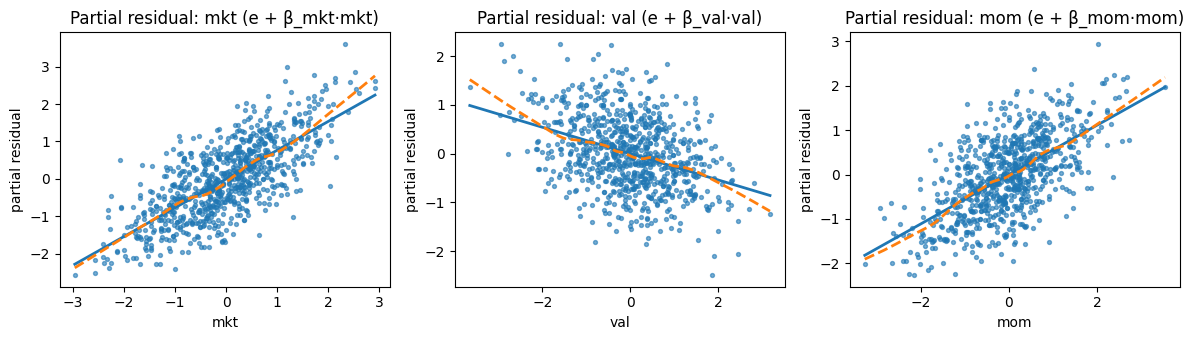

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Synthetic data
rng = np.random.default_rng(42)
n = 800
mkt = rng.normal(0, 1, n)
val = rng.normal(0, 1, n)
mom = 0.6*mkt + 0.8*rng.normal(0, 1, n)  # correlated with mkt
eps = 0.7*rng.normal(0, 1, n)

y = 0.2 + 0.8*mkt - 0.3*val + 0.5*mom + eps
df = pd.DataFrame({"y": y, "mkt": mkt, "val": val, "mom": mom})

# Fit OLS and get residuals
X = sm.add_constant(df[["mkt", "val", "mom"]])
res = sm.OLS(df["y"], X).fit()

e = res.resid
betas = res.params  # index: ["const","mkt","val","mom"]

# Build partial residuals for each predictor
pr = {name: e + betas[name] * df[name]
      for name in ["mkt", "val", "mom"]}

# Plot partial residuals vs each X_j
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=False)
for ax, name in zip(axes, ["mkt", "val", "mom"]):
    x = df[name].to_numpy()
    y_pr = pr[name].to_numpy()
    ax.scatter(x, y_pr, s=8, alpha=0.6)
    # OLS line of partial residual on X_j
    b1, b0 = np.polyfit(x, y_pr, 1)  # slope, intercept
    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, b1*xx + b0, linewidth=2)
    # LOWESS smooth
    lw = lowess(y_pr, x, frac=0.3, return_sorted=True)
    ax.plot(lw[:, 0], lw[:, 1], linewidth=2, linestyle="--")
    ax.set_title(f"Partial residual: {name} (e + β_{name}·{name})")
    ax.set_xlabel(name)
    ax.set_ylabel("partial residual")

plt.tight_layout()
plt.show()

Standard residual diagnostic

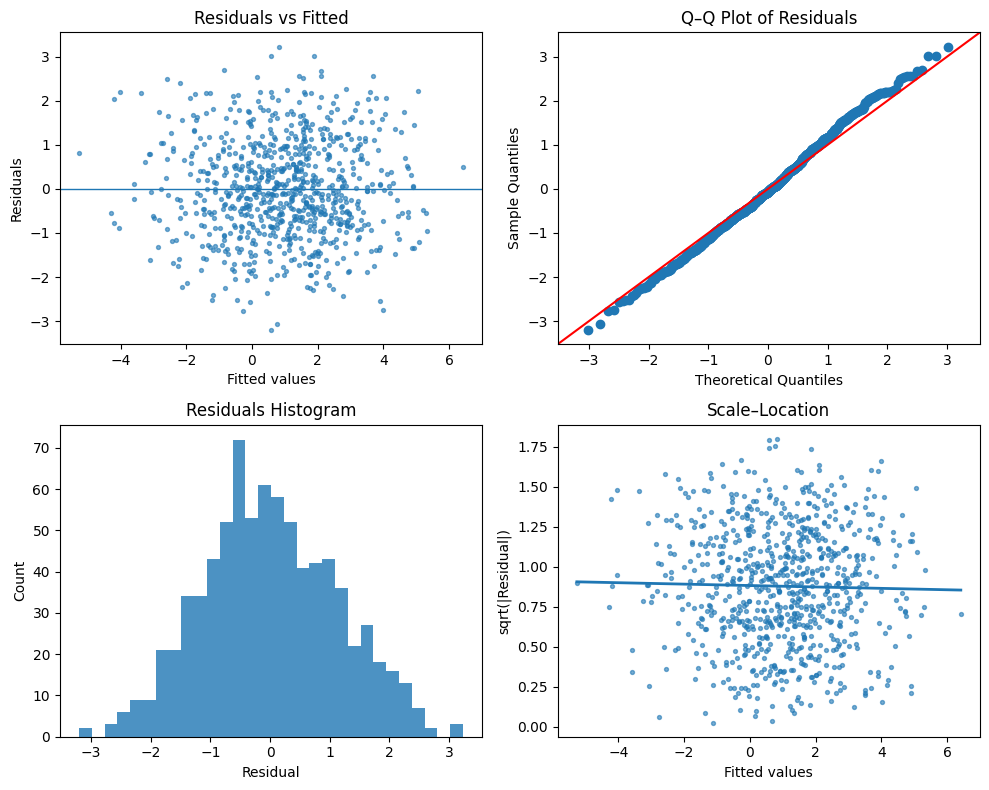

Breusch–Pagan: LM=2.773, p=0.4280, F=0.923, p=0.4292
Durbin–Watson: 1.951
Ljung–Box (lag 10):
  lb_stat  lb_pvalue
11.358158   0.330303
Jarque–Bera: stat=4.963, p=0.0836


In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera, durbin_watson

# Synthetic data
rng = np.random.default_rng(123)
n = 800
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
x3 = 0.5 * x1 + rng.normal(0, 1, n)
eps = rng.normal(0, 1, n) * (1 + 0.2 * np.abs(x1))  # mild heteroskedasticity
y = 1.0 + 1.2 * x1 - 0.8 * x2 + 0.4 * x3 + eps
df = pd.DataFrame({"y": y, "x1": x1, "x2": x2, "x3": x3})

# Fit OLS
X = sm.add_constant(df[["x1", "x2", "x3"]])
res = sm.OLS(df["y"], X).fit()

# Residuals and fitted
e = res.resid
f = res.fittedvalues

# Diagnostics
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# (Residuals vs fitted
axes[0, 0].scatter(f, e, s=8, alpha=0.6)
axes[0, 0].axhline(0, linewidth=1)
axes[0, 0].set_xlabel("Fitted values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_title("Residuals vs Fitted")

# (Q–Q plot
sm.qqplot(e, line="45", ax=axes[0, 1])
axes[0, 1].set_title("Q–Q Plot of Residuals")

# Histogram of residuals
axes[1, 0].hist(e, bins=30, alpha=0.8)
axes[1, 0].set_title("Residuals Histogram")
axes[1, 0].set_xlabel("Residual")
axes[1, 0].set_ylabel("Count")

# Scale–Location: sqrt(|e|) vs fitted
axes[1, 1].scatter(f, np.sqrt(np.abs(e)), s=8, alpha=0.6)
z = np.polyfit(f, np.sqrt(np.abs(e)), 1)
xx = np.linspace(f.min(), f.max(), 200)
axes[1, 1].plot(xx, z[0] * xx + z[1], linewidth=2)
axes[1, 1].set_xlabel("Fitted values")
axes[1, 1].set_ylabel("sqrt(|Residual|)")
axes[1, 1].set_title("Scale–Location")

plt.tight_layout()
plt.show()

# Statistical tests
# Breusch–Pagan for heteroskedasticity
bp_stat, bp_pval, bp_f, bp_fp = het_breuschpagan(e, res.model.exog)

# Durbin–Watson (2 ~ no autocorr; <2 positive; >2 negative)
dw = durbin_watson(e)

# Ljung–Box for autocorrelation at multiple lags
lb = acorr_ljungbox(e, lags=[10], return_df=True)

# Jarque–Bera for normality
jb_stat, jb_pval, _, _ = jarque_bera(e)

print("Breusch–Pagan: LM={:.3f}, p={:.4f}, F={:.3f}, p={:.4f}".format(bp_stat, bp_pval, bp_f, bp_fp))
print("Durbin–Watson: {:.3f}".format(dw))
print("Ljung–Box (lag 10):")
print(lb.to_string(index=False))
print("Jarque–Bera: stat={:.3f}, p={:.4f}".format(jb_stat, jb_pval))

Polynomial regression

CV RMSE by degree:
  degree  rmse_mean  rmse_std
      1   3.036825  0.103634
      2   2.267866  0.139155
      3   2.010812  0.110353
      4   2.011637  0.110691
      5   2.022568  0.115215

Selected degree by CV: 3

OLS summary (HC1 robust):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1450.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          2.33e-273
Time:                        14:01:34   Log-Likelihood:                -1268.7
No. Observations:                 600   AIC:                             2545.
Df Residuals:                     596   BIC:                             2563.
Df Model:                           3                                         
Covariance Type:                  HC1     

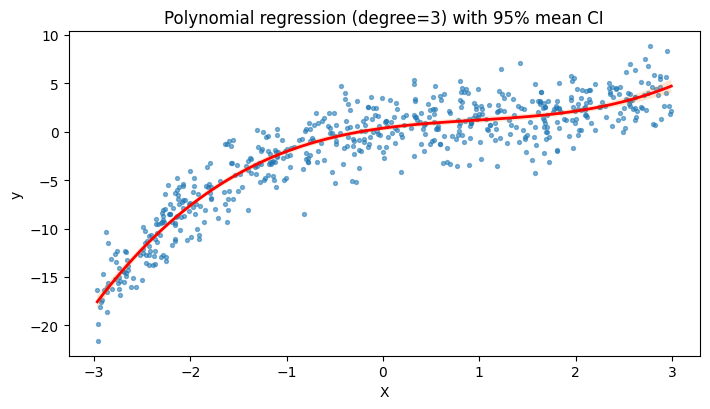

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Synthetic nonlinear data
rng = np.random.default_rng(42)
n = 600
X = rng.uniform(-3, 3, size=n)           # single predictor
# True nonlinear relation:  y = 0.5 + 1.2 x - 0.8 x^2 + 0.3 x^3 + noise
y = 0.5 + 1.2*X - 0.8*X**2 + 0.3*X**3 + rng.normal(0, 2.0, size=n)

# Select polynomial degree by cross-validated RMSE
degrees = [1, 2, 3, 4, 5]
kf = KFold(n_splits=5, shuffle=True, random_state=123)

cv_table = []
for d in degrees:
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin", LinearRegression())
    ])
    neg_mse = cross_val_score(pipe, X.reshape(-1, 1), y, cv=kf,
                              scoring="neg_mean_squared_error")
    rmse = np.sqrt(-neg_mse)
    cv_table.append((d, rmse.mean(), rmse.std()))

cv_df = pd.DataFrame(cv_table, columns=["degree", "rmse_mean", "rmse_std"]).sort_values("degree")
print("CV RMSE by degree:\n", cv_df.to_string(index=False))

best_degree = int(cv_df.loc[cv_df["rmse_mean"].idxmin(), "degree"])
print(f"\nSelected degree by CV: {best_degree}")

# Refit chosen degree with statsmodels for inference
# Standardize X before building polynomial terms to improve conditioning
scaler = StandardScaler().fit(X.reshape(-1, 1))
X_std = scaler.transform(X.reshape(-1, 1))

poly = PolynomialFeatures(degree=best_degree, include_bias=False)
Z = poly.fit_transform(X_std)            # polynomial features of standardized X
Zc = sm.add_constant(Z)                  # add intercept column
res = sm.OLS(y, Zc).fit(cov_type="HC1")  # heteroskedasticity-robust SEs
print("\nOLS summary (HC1 robust):")
print(res.summary())

# Smooth predictions + 95% CI for the mean
x_grid = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
xg_std = scaler.transform(x_grid)
Zg = poly.transform(xg_std)
Zgc = sm.add_constant(Zg)

pred = res.get_prediction(Zgc).summary_frame(alpha=0.05)
yhat = pred["mean"].to_numpy()
ci_lo = pred["mean_ci_lower"].to_numpy()
ci_hi = pred["mean_ci_upper"].to_numpy()

# Plot data, fitted curve, and CI band
plt.figure(figsize=(7.2, 4.2))
plt.scatter(X, y, s=8, alpha=0.55)
plt.plot(x_grid.ravel(), yhat, linewidth=2, c='r')
plt.fill_between(x_grid.ravel(), ci_lo, ci_hi, alpha=0.2)
plt.xlabel("X")
plt.ylabel("y")
plt.title(f"Polynomial regression (degree={best_degree}) with 95% mean CI")
plt.tight_layout()
plt.show()

LASSO regression

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Synthetic sparse problem (n << p possible; here n > p but sparse β)
rng = np.random.default_rng(42)
n, p = 1000, 60
X = rng.normal(size=(n, p))

# True sparse coefficients (only a few non-zeros)
true_beta = np.zeros(p)
true_map = {0: 1.5, 4: -2.0, 7: 0.8, 10: -1.2, 15: 1.0, 23: -0.7, 31: 0.9, 45: -1.1}
for j, v in true_map.items():
    true_beta[j] = v

beta0 = 0.3
noise = rng.normal(0, 1.0, size=n)
y = beta0 + X @ true_beta + noise

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=123, shuffle=True)

# Standardize predictors (critical for L1 penalties)
scaler = StandardScaler().fit(X_tr)
X_tr_std = scaler.transform(X_tr)
X_te_std = scaler.transform(X_te)

# Cross-validated alpha (λ) selection with LassoCV
alphas = np.logspace(-3, 1, 60)  # from 1e-3 to 10
cv = KFold(n_splits=5, shuffle=True, random_state=123)

lasso_cv = LassoCV(alphas=alphas, cv=cv, random_state=123, max_iter=10000)
lasso_cv.fit(X_tr_std, y_tr)

best_alpha = float(lasso_cv.alpha_)
cv_mse_mean = lasso_cv.mse_path_.mean(axis=1)
cv_rmse_min = float(np.sqrt(cv_mse_mean.min()))

print(f"Selected alpha (λ): {best_alpha:.6f}")
print(f"Min CV RMSE: {cv_rmse_min:.4f}")

# Refit final LASSO at the selected alpha and evaluate OOS
final = Lasso(alpha=best_alpha, max_iter=10000)
final.fit(X_tr_std, y_tr)

yhat_tr = final.predict(X_tr_std)
yhat_te = final.predict(X_te_std)

rmse_tr = float(np.sqrt(mean_squared_error(y_tr, yhat_tr)))
rmse_te = float(np.sqrt(mean_squared_error(y_te, yhat_te)))
r2_tr = float(r2_score(y_tr, yhat_tr))
r2_te = float(r2_score(y_te, yhat_te))

print(f"Train RMSE: {rmse_tr:.4f} | R^2: {r2_tr:.4f}")
print(f" Test RMSE: {rmse_te:.4f} | R^2: {r2_te:.4f}")

# Sparsity summary and coefficient table (on standardized X scale)
coef = final.coef_
nz_idx = np.flatnonzero(coef)
print(f"Selected (non-zero) coefficients: {len(nz_idx)} of {p}")

coef_df = pd.DataFrame({
    "feature": [f"x{j}" for j in range(p)],
    "coef": coef,
    "abs_coef": np.abs(coef),
    "true_beta": true_beta
}).sort_values("abs_coef", ascending=False)

print("\nTop selected features by |coef|:")
print(coef_df.head(10).drop(columns=["abs_coef"]).to_string(index=False))

Selected alpha (λ): 0.042376
Min CV RMSE: 1.0192
Train RMSE: 0.9874 | R^2: 0.9223
 Test RMSE: 0.9456 | R^2: 0.9322
Selected (non-zero) coefficients: 18 of 60

Top selected features by |coef|:
feature      coef  true_beta
     x4 -1.879538       -2.0
     x0  1.480078        1.5
    x10 -1.141984       -1.2
    x45 -1.059396       -1.1
    x15  0.967853        1.0
    x31  0.784141        0.9
     x7  0.770267        0.8
    x23 -0.675666       -0.7
     x5 -0.056385        0.0
    x38 -0.047512        0.0


Ridge regression

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Synthetic data with multicollinearity
rng = np.random.default_rng(42)
n, p = 1000, 12

# Correlated block (x0, x1, x2) via a common driver g
g = rng.normal(size=n)
x0 = g + 0.10*rng.normal(size=n)
x1 = 0.9*g + 0.10*rng.normal(size=n)
x2 = 0.8*g + 0.10*rng.normal(size=n)

# Remaining features (some correlated pairs, some independent)
x3 = rng.normal(size=n)
x4 = 0.7*x3 + 0.30*rng.normal(size=n)
x5 = rng.normal(size=n)
x6 = rng.normal(size=n)
x7 = 0.6*x6 + 0.40*rng.normal(size=n)
x8 = rng.normal(size=n)
x9 = rng.normal(size=n)
x10 = rng.normal(size=n)
x11 = rng.normal(size=n)

X = np.column_stack([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11])
cols = [f"x{j}" for j in range(p)]
dfX = pd.DataFrame(X, columns=cols)

# True coefficients (dense-ish; correlated block has similar weights)
beta_true = np.array([0.8, 0.7, 0.7,  0.5, 0.4, 0.0,
                      0.5, 0.4, 0.0,  0.2, 0.0, 0.1])
beta0 = 0.3
noise = rng.normal(0, 1.0, size=n)
y = beta0 + X @ beta_true + noise

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(dfX, y, test_size=0.25,
                                          random_state=123, shuffle=True)

# Scaling inside CV (to avoid leakage)
ridge_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(fit_intercept=True, random_state=None))])

ols_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ols", LinearRegression())])

# Cross-validated alpha (λ) search for Ridge
alphas = np.logspace(-3, 3, 60)  # 1e-3 ... 1e+3
param_grid = {"ridge__alpha": alphas}
kf = KFold(n_splits=5, shuffle=True, random_state=123)

grid = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    cv=kf,
    scoring="neg_mean_squared_error",
    n_jobs=None,
    refit=True)
grid.fit(X_tr, y_tr)

best_alpha = float(grid.best_params_["ridge__alpha"])
cv_rmse_mean = float(np.sqrt(-grid.best_score_))
cv_rmse_std = float(np.std(np.sqrt(-grid.cv_results_["mean_test_score"])))  # rough

print(f"Selected alpha (λ): {best_alpha:.6f}")
print(f"5-fold CV RMSE: mean={cv_rmse_mean:.4f} (std ~ {cv_rmse_std:.4f})")

# Fit OLS baseline on the same split
ols_pipe.fit(X_tr, y_tr)

# Evaluate on held-out test data
ridge_best = grid.best_estimator_
yhat_r_tr = ridge_best.predict(X_tr)
yhat_r_te = ridge_best.predict(X_te)
yhat_o_tr = ols_pipe.predict(X_tr)
yhat_o_te = ols_pipe.predict(X_te)

def metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    return rmse, r2

rmse_r_tr, r2_r_tr = metrics(y_tr, yhat_r_tr)
rmse_r_te, r2_r_te = metrics(y_te, yhat_r_te)
rmse_o_tr, r2_o_tr = metrics(y_tr, yhat_o_tr)
rmse_o_te, r2_o_te = metrics(y_te, yhat_o_te)

print(f"\nRidge (α={best_alpha:.4g})  | Train RMSE={rmse_r_tr:.4f}, R^2={r2_r_tr:.4f} | "
      f"Test RMSE={rmse_r_te:.4f}, R^2={r2_r_te:.4f}")
print(f"OLS (unregularized) | Train RMSE={rmse_o_tr:.4f}, R^2={r2_o_tr:.4f} | "
      f"Test RMSE={rmse_o_te:.4f}, R^2={r2_o_te:.4f}")

# Coefficient comparison (standardized feature scale inside each pipeline)
ridge_coef = ridge_best.named_steps["ridge"].coef_
ridge_int = float(ridge_best.named_steps["ridge"].intercept_)
ols_coef = ols_pipe.named_steps["ols"].coef_
ols_int = float(ols_pipe.named_steps["ols"].intercept_)

coef_df = pd.DataFrame({
    "feature": cols,
    "ridge_coef(stdX)": ridge_coef,
    "ols_coef(stdX)": ols_coef,
    "true_beta": beta_true
}).assign(abs_ridge=lambda d: np.abs(d["ridge_coef(stdX)"])) \
  .sort_values("abs_ridge", ascending=False)

print("\nTop coefficients by |ridge_coef(stdX)|:")
print(coef_df[["feature", "ridge_coef(stdX)", "ols_coef(stdX)", "true_beta"]]
      .head(10).to_string(index=False))

print(f"\nIntercepts (note: pipelines standardize X): "
      f"ridge={ridge_int:.4f}, ols={ols_int:.4f}")

Selected alpha (λ): 23.598335
5-fold CV RMSE: mean=1.0409 (std ~ 0.0589)

Ridge (α=23.6)  | Train RMSE=1.0258, R^2=0.8201 | Test RMSE=0.9722, R^2=0.8393
OLS (unregularized) | Train RMSE=1.0250, R^2=0.8204 | Test RMSE=0.9720, R^2=0.8394

Top coefficients by |ridge_coef(stdX)|:
feature  ridge_coef(stdX)  ols_coef(stdX)  true_beta
     x2          0.722183        0.914553        0.7
     x1          0.609561        0.555522        0.7
     x0          0.590873        0.473873        0.8
     x3          0.453225        0.486943        0.5
     x7          0.439661        0.456165        0.4
     x6          0.356036        0.353270        0.5
     x4          0.326794        0.307411        0.4
     x9          0.188379        0.194672        0.2
    x11          0.110985        0.115881        0.1
     x5          0.065396        0.066968        0.0

Intercepts (note: pipelines standardize X): ridge=0.2401, ols=0.2401
